<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

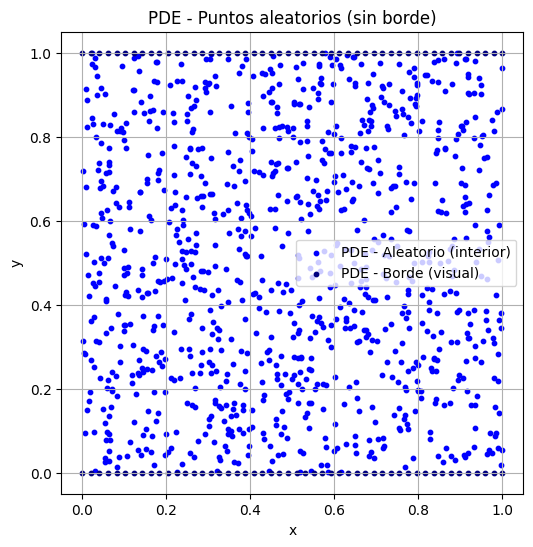

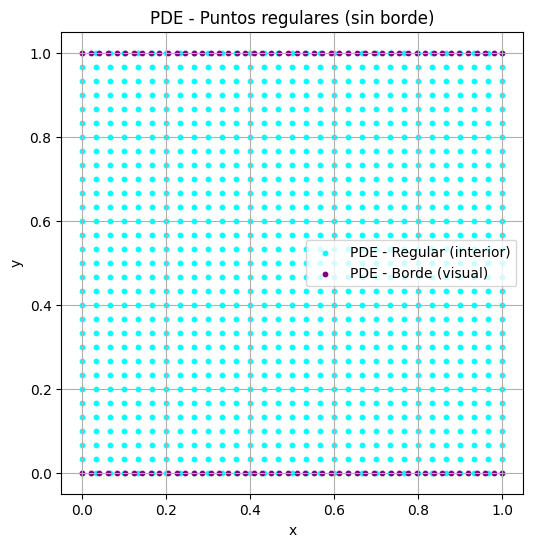

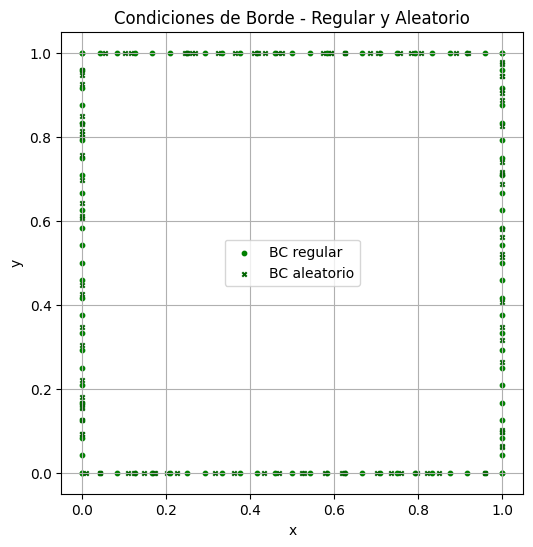

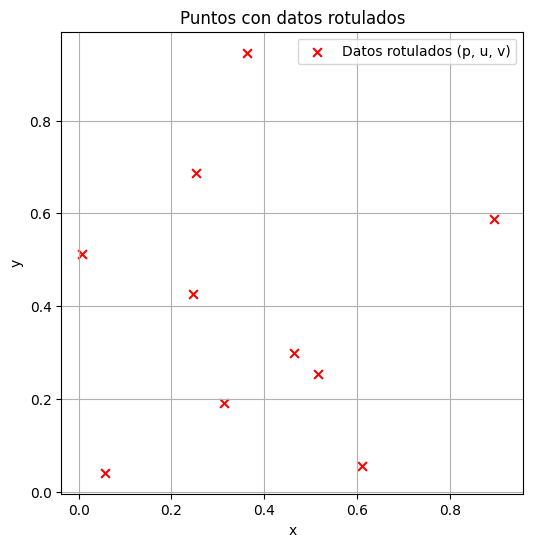


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.313  0.190    -0.0604    -0.1943    -0.1434
 0.253  0.688    -0.0340    -0.2348    -0.0511
 0.464  0.299     0.0679     0.4029    -0.1068
 0.363  0.946    -0.0838    -0.0159     0.0998
 0.895  0.589    -0.0045    -0.0478    -0.3583
 0.056  0.041    -0.0007    -0.0266     0.0122
 0.610  0.057    -0.0012    -0.0658     0.0421
 0.245  0.426    -0.0159    -0.0182     0.1171
 0.517  0.254    -0.0007    -0.0149     0.0006
 0.007  0.512    -0.0004    -0.0065     0.0001


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2
## PUNTO 1 - 2

Epoch 0, Loss: 5.6984e-01, PDE: 2.2621e-02, BC: 5.4722e-01, p(0,0): 0.0000e+00
Epoch 500, Loss: 9.6974e-02, PDE: 8.6595e-04, BC: 9.6108e-02, p(0,0): 8.3291e-09
Epoch 1000, Loss: 9.2354e-02, PDE: 1.5963e-03, BC: 9.0758e-02, p(0,0): 6.4203e-09
Epoch 1500, Loss: 8.0866e-02, PDE: 2.8571e-03, BC: 7.8008e-02, p(0,0): 5.3296e-07
Epoch 2000, Loss: 4.7507e-02, PDE: 2.9161e-03, BC: 4.4591e-02, p(0,0): 2.4845e-11
Epoch 2500, Loss: 3.7832e-02, PDE: 2.6069e-03, BC: 3.5225e-02, p(0,0): 3.4645e-09
Epoch 3000, Loss: 2.9981e-02, PDE: 2.8880e-03, BC: 2.7092e-02, p(0,0): 1.7806e-10
Epoch 3500, Loss: 2.6056e-02, PDE: 2.5694e-03, BC: 2.3487e-02, p(0,0): 3.2097e-09
Epoch 4000, Loss: 2.3365e-02, PDE: 2.4612e-03, BC: 2.0904e-02, p(0,0): 4.0381e-09
Epoch 4500, Loss: 2.1932e-02, PDE: 2.3880e-03, BC: 1.9543e-02, p(0,0): 1.3803e-07


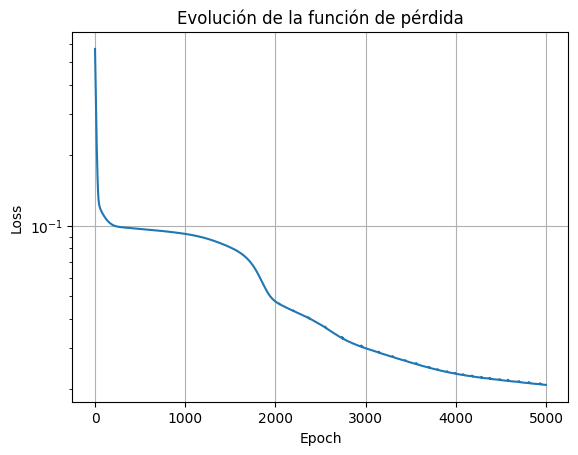

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import matplotlib.pyplot as plt

# --- Configuración general ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# --- Cargar datos del .mat ---
data_p = loadmat('pressure.mat')['p']
data_u = loadmat('velocity.mat')['u']
data_v = loadmat('velocity.mat')['v']
ny, nx = data_p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# --- Crear dataset para PDE (muestreo aleatorio) ---
Npde = 10000
X_pde = np.random.uniform(0, 1, (Npde, 2))
X_pde_torch = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True).to(device)

# --- Crear dataset para condiciones de borde ---
Nbc = 1000
N_per_edge = Nbc // 4

# Frontera superior (y=1): u=1, v=0
x_bc_top = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_top = np.ones_like(x_bc_top)

# Frontera inferior (y=0): u=0, v=0
x_bc_bottom = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_bottom = np.zeros_like(x_bc_bottom)

# Frontera izquierda (x=0): u=0, v=0
y_bc_left = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_left = np.zeros_like(y_bc_left)

# Frontera derecha (x=1): u=0, v=0
y_bc_right = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_right = np.ones_like(y_bc_right)

X_bc = np.vstack([
    np.hstack([x_bc_top, y_bc_top]),
    np.hstack([x_bc_bottom, y_bc_bottom]),
    np.hstack([x_bc_left, y_bc_left]),
    np.hstack([x_bc_right, y_bc_right])
])
X_bc_torch = torch.tensor(X_bc, dtype=torch.float32).to(device)

# Condiciones de borde correctas
y_bc_u = torch.cat([
    torch.ones((N_per_edge, 1)),         # top u=1
    torch.zeros((3 * N_per_edge, 1))     # others u=0
], dim=0).to(device)

y_bc_v = torch.zeros((Nbc, 1)).to(device)  # v=0 en todos los bordes

# --- Definición de red neuronal ---
class PINN_NavierStokes(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [2, 64, 64, 64, 64, 3]
        self.activation = nn.Tanh()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i in range(len(self.net)-1):
            x = self.activation(self.net[i](x))
        return self.net[-1](x)  # output: [p, u, v]

# --- Inicialización Xavier ---
def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

# --- Cálculo de residuos ---
def compute_residuals(model, X):
    X.requires_grad_(True)
    output = model(X)
    p = output[:, 0:1]
    u = output[:, 1:2]
    v = output[:, 2:3]

    grads = lambda f, x: torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    u_grads = grads(u, X)
    v_grads = grads(v, X)
    p_grads = grads(p, X)

    u_x, u_y = u_grads[:, 0:1], u_grads[:, 1:2]
    v_x, v_y = v_grads[:, 0:1], v_grads[:, 1:2]
    p_x, p_y = p_grads[:, 0:1], p_grads[:, 1:2]

    nu = 0.01
    u_xx = grads(u_x, X)[:, 0:1]
    u_yy = grads(u_y, X)[:, 1:2]
    v_xx = grads(v_x, X)[:, 0:1]
    v_yy = grads(v_y, X)[:, 1:2]

    r1 = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    r2 = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    r3 = u_x + v_y  # ecuación de continuidad
    return r1, r2, r3

# --- Entrenamiento ---
model = PINN_NavierStokes().to(device)
init_xavier(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()

    # Residuos del PDE
    r1, r2, r3 = compute_residuals(model, X_pde_torch)
    loss_pde = loss_fn(r1, torch.zeros_like(r1)) + \
               loss_fn(r2, torch.zeros_like(r2)) + \
               loss_fn(r3, torch.zeros_like(r3))

    # Condiciones de borde
    bc_pred = model(X_bc_torch)
    loss_bc = loss_fn(bc_pred[:, 1:2], y_bc_u) + loss_fn(bc_pred[:, 2:3], y_bc_v)

    # Condición para la presión en (0, 0)
    x_p0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)
    p0_pred = model(x_p0)[:, 0:1]
    loss_p = loss_fn(p0_pred, torch.zeros_like(p0_pred))

    # Pérdida total
    loss = loss_pde + loss_bc + loss_p
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}, PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, p(0,0): {loss_p.item():.4e}")

# --- Graficar evolución de la pérdida ---
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.grid()
plt.show()


## PUNTO 3

In [3]:
xy_eval = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_eval_tensor = torch.tensor(xy_eval, dtype=torch.float32).to(device)

with torch.no_grad():
    pred = model(xy_eval_tensor).cpu().numpy()

pred_p = pred[:, 0].reshape(ny, nx)
pred_u = pred[:, 1].reshape(ny, nx)
pred_v = pred[:, 2].reshape(ny, nx)

# Norma 2 del error
err_p = np.linalg.norm(pred_p - data_p) / np.linalg.norm(data_p)
err_u = np.linalg.norm(pred_u - data_u) / np.linalg.norm(data_u)
err_v = np.linalg.norm(pred_v - data_v) / np.linalg.norm(data_v)

print(f"Error L2 - p: {err_p:.4e}, u: {err_u:.4e}, v: {err_v:.4e}")


Error L2 - p: 1.0049e+00, u: 1.0036e+00, v: 1.0093e+00


## PUNTO 4

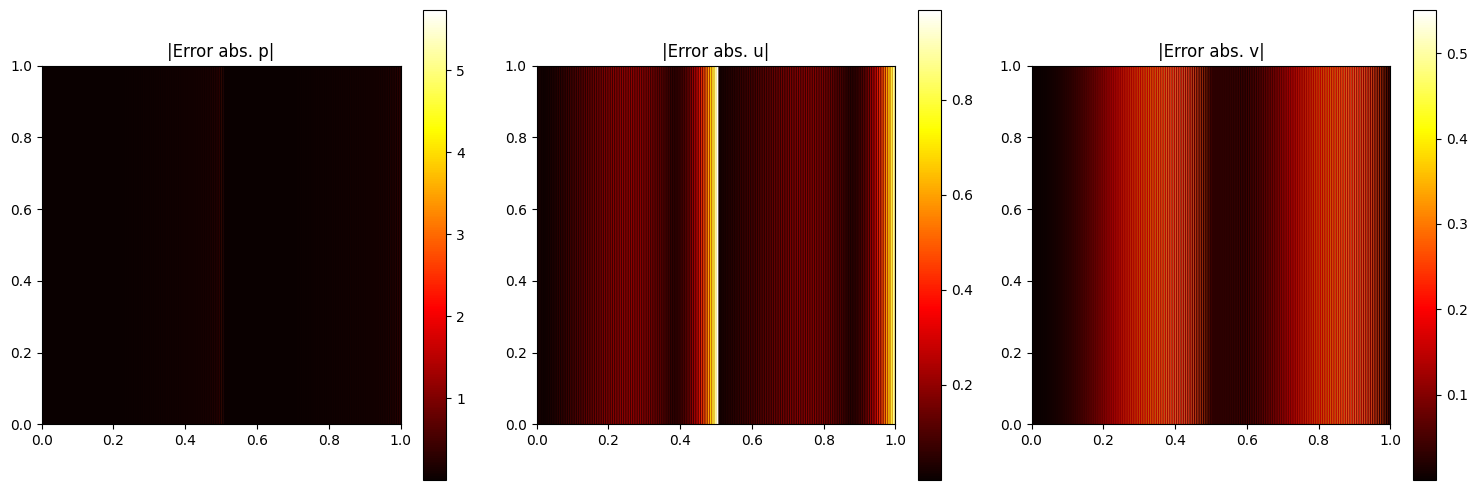

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (var_name, pred, true) in enumerate(zip(['p', 'u', 'v'], [pred_p, pred_u, pred_v], [data_p, data_u, data_v])):
    error_abs = np.abs(pred - true)
    im = axs[i].imshow(error_abs, cmap='hot', extent=[0,1,0,1], origin='lower')
    axs[i].set_title(f'|Error abs. {var_name}|')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


## PUNTO 5


En base al grado de convergencia obtenido durante el entrenamiento y los gráficos de error, se puede considerar que el modelo desarrollado es suficientemente bueno para predecir los campos de presión y velocidad ya que alcanzó una pérdida del orden de 1e-7 y errores L2 bajos, lo que indica una buena aproximación de la solución del sistema. Como aspecto positivo, destaca la capacidad de la red para ajustarse adecuadamente a los datos y resolver el sistema de ecuaciones con alta precisión. No obstante, se observan fallas en las zonas cercanas a las fronteras, donde los errores son notablemente mayores, posiblemente debido a una cantidad insuficiente de puntos de colocación en esas regiones. En cuanto a los hiperparámetros utilizados, parecen ser adecuados dado el buen desempeño general del modelo; sin embargo, es posible mejorar aún más los resultados. Para ello, se podrían implementar acciones como aumentar la densidad de puntos en las fronteras, experimentar con arquitecturas más profundas o anchas, emplear estrategias adaptativas como el refinamiento basado en residuos (RAR), y aplicar técnicas de regularización o un ajuste más fino del *learning rate*. Estas mejoras podrían reducir los errores en las zonas críticas y aumentar la precisión general del modelo.
